# Pipeline for creating VADER sentiment scores

This notebook accepts a body of user comments and uses the VADER sentiment scoring system to find a distribution of positive-negative intensity scores grouped by original article or post.

A measure of distritution variance is then used as a target for our machine learning feature set.

## About VADER scores
Source VADER: https://github.com/cjhutto/vaderSentiment

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based mechanism trained on social media datasets that provides scores for strings of text ranging from -1 (extremely negative) to +1 (extremely postive).

It computes a total score (compound score) for a sentence by looking up the sentiment score assigned to each individual word and then applying learned rules to modify these scores based on context.

The values returned on a call to polarity_scores(string) are the positive, negative and neutral parts of the string and a post-rule computed compound score.

This is in the form: {'compound': 0.4199, 'neg': 0.0, 'neu': 0.417, 'pos': 0.583}



In [3]:
# Install VADER if needed. Uncomment & run.
#!pip install vaderSentiment

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia

### Assigning Parameters

In [80]:
# Dataset Specific Parameters
FILE_PATH = './'

MIN_COMMENT_COUNT = 5

OUTPUT_COLS = ['id',
               'topic',
               'source',
               'text',
               'replyCount',
               'vaderMean',
               'vaderStd',
               'vaderCatLabel',
               'vaderCat']


## for the NYT news archive from Kaggle uncomment:
#MAIN_ID = 'articleID'
#MAIN_TEXT = 'snippet'
#REPLY_ID = 'commentID'
#REPLY_TEXT = 'commentBody'
#TOPIC = 'newDesk'  # needed
#SOURCE = 'kaggle'
#REPLY_FILE = 'article_comments.csv'
#MAIN_FILE = 'articles.csv'
#EXPORT_NAME = 'articles_w_scores.csv'


## for the tweet dataset uncomment:
MAIN_ID = 'ConversationId'
MAIN_TEXT = 'Text'
REPLY_ID = 'TweetId'
REPLY_TEXT = 'Text'
TOPIC = 'Topic' #this should change after topics updated
SOURCE = 'Username'
    
REPLY_FILE = 'comments.csv'
MAIN_FILE = 'tweets.csv'
EXPORT_NAME = 'tweets_all.csv'

### Setting up VADER scoring

In [57]:
# vader initialized
vader = sia()

In [58]:
def getScore(string):
  scoreDict = vader.polarity_scores(string)
  return scoreDict["compound"]

### Importing Replies

In [60]:
# reply data import
comments = pd.read_csv(FILE_PATH + "data/" + REPLY_FILE)
comments = comments[comments[REPLY_TEXT].notnull()]
print('total comments: ',comments.shape[0])

total comments:  1300586


### Applying Scores

In [61]:
# applying scores
comments["vaderScore"] = comments[REPLY_TEXT].map(getScore)

In [62]:
# creating aggregations by original post

articles = comments.groupby(MAIN_ID)['vaderScore'].agg(['count',
                                                        'mean',
                                                        'min', 
                                                        'max',
                                                        'std'])
articles = articles.reset_index()
articles[MAIN_ID] = articles[MAIN_ID].astype('int')

articles["firstQ"] = (comments.groupby(MAIN_ID)['vaderScore']
                      .quantile(.25).reset_index()['vaderScore'])

articles["thirdQ"] = (comments.groupby(MAIN_ID)['vaderScore']
                      .quantile(.75).reset_index()['vaderScore'])

articles["iq_range"] = abs(articles["firstQ"] - articles['thirdQ'])

articles["range"] = abs(articles['min'] - articles['max'])

articles = articles[[MAIN_ID, 'count', 'mean', 'std', 'iq_range']]
articles.columns = [MAIN_ID, 'commentCount', 
                    'vaderMean', 'vaderStd', 'vaderIQR']

articles = articles[articles['commentCount'] >= MIN_COMMENT_COUNT]
print(MIN_COMMENT_COUNT)
articles.head()

5


,ConversationId,commentCount,vaderMean,vaderStd,vaderIQR
1,1366177614491189251,8,-0.432250,0.488816,0.68525
4,1366181408969007104,28,-0.028793,0.486646,0.95100
6,1366182689074782210,28,-0.055679,0.404533,0.60810
7,1366182899049988105,6,0.098467,0.399020,0.54505
8,1366183905930342400,57,0.040970,0.415835,0.51430


## Analyzing for Category Cut-offs

### Expectations for Polarization Distributions

A completely random assignment of sentiment scores should have a mean that centers at 0 and tails that approach -1 and 1. Setting the 3rd standard deviation from the mean to these values give us a standard distribution around 1/3.

Since an unpolarizing post should have a distribution that results in comments that are less polarizing than a completely random assignment of scores, posts with standard deviations less than 1/3 can be considered unpolarized.

Similarly, two randomly assigned distributions of scores centering on -1 and 1 added together to form a bimodal distribution would also have a mean of zero but, it would indicate that the post creates two completely separate groups of replies, centered on the extremes. The standard deviation of such a distribution would be the sum of the sub-distributions: (1/3 + 1/3) = 2/3. 

Therefore we can reasonably assume a distritution with a standard deviation approaching 2/3 to be extremely polarized.

### Binning Standard Deviations

For the sake of simplification, and because tweets with standard deviations greater than 2/3 are rare in our dataset, first we use these markers as a general guideline and set up even bins between 0.3 and 0.6 to categorize the polarity of tweet sentiments.

**no polarization** \[0.0, 0.3\]  
**low polarization** (0.3, 0.4\]  
**medium polarization** (0.4, 0.5\]  
**high polarization** (0.5, 0.6\]  
**extreme polarization** (0.6, inf\)

The counts, especially in the lower levels of polarization are low.
To make the sample balance better, we tried rebinning into three categories.

**low polarization** \[0.0, 0.4\]  
**medium polarization** (0.4, 0.5\]  
**high polarization** (0.5, inf\)




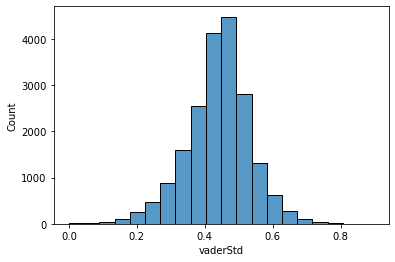

In [63]:
sns.histplot(x='vaderStd',
             data=articles,
            bins=20)

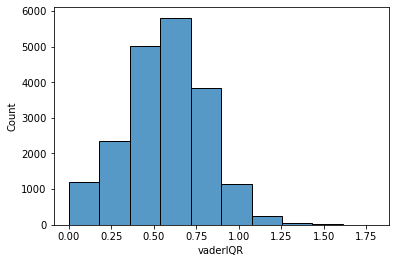

In [64]:
sns.histplot(x='vaderIQR',
             data=articles,
            bins=10)

### Adding Category Bins

In [81]:
articles['vaderCatLabel'] = "medium"
articles['vaderIQRLabel'] = "medium"

# five bins...
#articles.loc[articles['vaderStd'] <= 0.3, 'vaderCatLabel'] = "none"
#articles.loc[(articles['vaderStd'] > 0.3) &
#             (articles['vaderStd'] <= 0.4), 'vaderCatLabel'] = "low"
#articles.loc[(articles['vaderStd'] > 0.5) &
#             (articles['vaderStd'] <= 0.6), 'vaderCatLabel'] = "high"
#articles.loc[articles['vaderStd'] > 0.6, 'vaderCatLabel'] = "extreme"

#for val, label in enumerate(['none','low','medium', 'high',  'extreme']):
#    articles.loc[articles.vaderCatLabel == label, 'vaderCat'] = val


# three bins...
articles.loc[articles['vaderStd'] <= 0.4, 'vaderCatLabel'] = "low"
articles.loc[articles['vaderStd'] > 0.5, 'vaderCatLabel'] = "high"

articles.loc[articles['vaderIQR'] <= 0.45, 'vaderIQRLabel'] = "low"
articles.loc[articles['vaderIQR'] > 0.65, 'vaderIQRLabel'] = "high"

for val, label in enumerate(['low','medium', 'high']):
    articles.loc[articles.vaderCatLabel == label, 'vaderCat'] = val

articles.head()

,ConversationId,commentCount,vaderMean,vaderStd,vaderIQR,vaderCatLabel,vaderIQRLabel,vaderCat
1,1366177614491189251,8,-0.432250,0.488816,0.68525,medium,high,1.0
4,1366181408969007104,28,-0.028793,0.486646,0.95100,medium,high,1.0
6,1366182689074782210,28,-0.055679,0.404533,0.60810,medium,medium,1.0
7,1366182899049988105,6,0.098467,0.399020,0.54505,low,medium,0.0
8,1366183905930342400,57,0.040970,0.415835,0.51430,medium,medium,1.0


In [82]:
articles.groupby('vaderCatLabel')[MAIN_ID].count()

vaderCatLabel
high      4571
low       5684
medium    9450
Name: ConversationId, dtype: int64

### Merging with Original Posts and Exporting

In [83]:
# import main thread data 
main_df = pd.read_csv(FILE_PATH + "data/" + MAIN_FILE)

if SOURCE == 'kaggle':
    main_df['kaggle'] = 'nyt_kaggle'
    
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34301 entries, 0 to 34300
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Datetime        34301 non-null  object 
 1   TweetId         34301 non-null  int64  
 2   Text            34299 non-null  object 
 3   Username        34301 non-null  object 
 4   MentionedUsers  0 non-null      float64
 5   ConversationId  34301 non-null  int64  
 6   Topic           0 non-null      float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.8+ MB


In [84]:
# add standard deviation and categories
main_df = main_df.merge(articles, on=MAIN_ID, how='inner')

print("matched threads: ", main_df.shape[0])

# filter and rename columns
main_df = main_df[[MAIN_ID,
                   TOPIC,
                   SOURCE,
                   MAIN_TEXT,
                   'commentCount',
                   'vaderMean',
                   'vaderStd',
                   'vaderCatLabel',
                   'vaderCat']]

main_df.columns = OUTPUT_COLS

# export dataframe
main_df.to_csv(FILE_PATH + "data/" + EXPORT_NAME, index=False)

matched threads:  20698


In [85]:
main_df = pd.read_csv(FILE_PATH + 'data/tweets_all.csv')
main_df.head()

,id,topic,source,text,replyCount,vaderMean,vaderStd,vaderCatLabel,vaderCat
0,1377385383168765952,NaN,FoxNews,activists protest renaming chicago school afte...,306,-0.052830,0.445459,medium,1.0
1,1377384607969013765,NaN,FoxNews,border patrol video shows smugglers abandoning...,108,-0.045958,0.495337,medium,1.0
2,1377384339105669122,NaN,FoxNews,cause of tiger woods car crash determined but ...,169,-0.034919,0.424833,medium,1.0
3,1377367836046192641,NaN,FoxNews,gop rep urges hhs to halt reported plan to rel...,80,0.043459,0.495874,medium,1.0
4,1377358399759785987,NaN,FoxNews,some democrats trying to stop iowa new hampshi...,96,-0.040135,0.433053,medium,1.0
